In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math as mt
from pylab import savefig

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output


# Keras is a deep learning library that wraps the efficient numerical libraries Theano and TensorFlow.
# It provides a clean and simple API that allows you to define and evaluate deep learning models in just a few lines of code.from keras.models import Sequential, load_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint

# define custom R2 metrics for Keras backend
from keras import backend as K

# model evaluation
from sklearn.model_selection import KFold, train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# define path to save model
model_path = 'keras_model.h5'
seed = 1234

In [3]:
df = pd.read_csv('data/df_listing_high_renter_with_pic_data.csv')
TARGET = 'availability_90'

cols_text =  df.select_dtypes(include=['object']).columns.tolist()



df.drop(cols_text,axis=1,inplace=True)

df = df[~df.last_review.isnull()]
df = df[~df.review_scores_value.isnull()]
df = df[df.number_of_reviews>10]
df = df[df.availability_90>20]
#df = df[df.host_listings_count>1]

columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
print df_missing_data[df_missing_data.missing_percent>0]

Empty DataFrame
Columns: [missing_percent]
Index: []


In [4]:
X = df.drop(['availability_365','availability_90','availability_60'],axis=1)
X = X.drop('id',axis=1)
X = X.values

In [5]:
y = df[TARGET].values
X,X_test,y,y_test = train_test_split(X,y,test_size=.2)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [6]:
#########################################################################################################################################
# GENERATE MODEL
# The Keras wrappers require a function as an argument. 
# This function that we must define is responsible for creating the neural network model to be evaluated.
# Below we define the function to create the baseline model to be evaluated. 
# The network uses good practices such as the rectifier activation function for the hidden layer. 
# No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical 
# values directly without transform.# The efficient ADAM optimization algorithm is used and a mean squared error loss function is optimized. 
# This will be the same metric that we will use to evaluate the performance of the model. 
# It is a desirable metric because by taking the square root gives us an error value we can directly understand in the context of the problem.
##########################################################################################################################################

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
    
# Base model architecture definition.
# Dropout is a technique where randomly selected neurons are ignored during training. 
# They are dropped-out randomly. This means that their contribution to the activation.
# of downstream neurons is temporally removed on the forward pass and any weight updates are
# not applied to the neuron on the backward pass.
# More info on Dropout here http://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# BatchNormalization, Normalize the activations of the previous layer at each batch, i.e. applies a transformation 
# that maintains the mean activation close to 0 and the activation standard deviation close to 1.
def model():
    model = Sequential()
    #input layer
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    # hidden layers
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation(act_func))
    model.add(Dropout(0.4))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation(act_func))
    model.add(Dropout(0.4))
    
    model.add(Dense(input_dims//4, activation=act_func))
    
    # output layer (y_pred)
    model.add(Dense(1, activation='linear'))
    
    # compile this model
    model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam',
                  metrics=[r2_keras] # you can add several if needed
                 )
    # Visualize NN architecture
    print(model.summary())
    return model

#activation functions for hidden layers
act_func = 'sigmoid' # could be 'relu', 'sigmoid', ...tanh

# initialize input dimension

input_dims = X.shape[1]
# input_dims = train_reduced.shape[1]

# initialize estimator, wrap model in KerasRegressor
estimator = KerasRegressor(
    build_fn=model, 
    nb_epoch=300, 
    batch_size=30,
    verbose=1
)

# X, y preparation


print('\nTrain shape No Feature Selection: {}\nTest shape No Feature Selection: {}'.format(X.shape, X_test.shape))


Train shape No Feature Selection: (985, 575)
Test shape No Feature Selection: (247, 575)


In [7]:
###############
# K-FOLD
###############
"""Return the sample arithmetic mean of data."""
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
"""Return sum of square deviations of sequence data."""    
def sum_of_square_deviation(numbers,mean):
    return float(1/len(numbers) * sum((x - mean)** 2 for x in numbers))    
  

n_splits = 4
kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
kf.get_n_splits(X)

mse_scores = list()
r2_scores = list()

for fold, (train_index, test_index) in enumerate(kf.split(X)):
   
    
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    # prepare callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_r2_keras', 
            patience=20,
            mode='max',
            verbose=1)
    ]
    # fit estimator
    history = estimator.fit(
        X_tr, 
        y_tr, 
        epochs=500,
        validation_data=(X_val, y_val),
        verbose=2,
        callbacks=callbacks,
        shuffle=True
    )
    
    pred = estimator.predict(X_val)
    
    mse = mean_squared_error(y_val, estimator.predict(X_val))**0.5
    r2 = r2_score(y_val, estimator.predict(X_val))
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print('Fold %d: Mean Squared Error %f'%(fold, mse))
    print('Fold %d: R^2 %f'%(fold, r2))

    #save results
    pred = estimator.predict(X_test)
    output = pd.DataFrame({'y': pred})
    output.to_csv(str(r2)+'_submission_keras.csv', index=False)
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 575)               331200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 575)               2300      
_________________________________________________________________
activation_1 (Activation)    (None, 575)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 575)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 575)               331200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 575)               2300      
_________________________________________________________________
activation_2 (Activation)    (None, 575)               0         
__________

Mean Squared Error 14.637972
Stdev Squared Error 0.000000
Mean R^2 0.360012
Stdev R^2 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 575)               331200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 575)               2300      
_________________________________________________________________
activation_13 (Activation)   (None, 575)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 575)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 575)               331200    
_________________________________________________________________
batch_normalization_14 (Batc (None, 575)               2300      
_______________________________________________

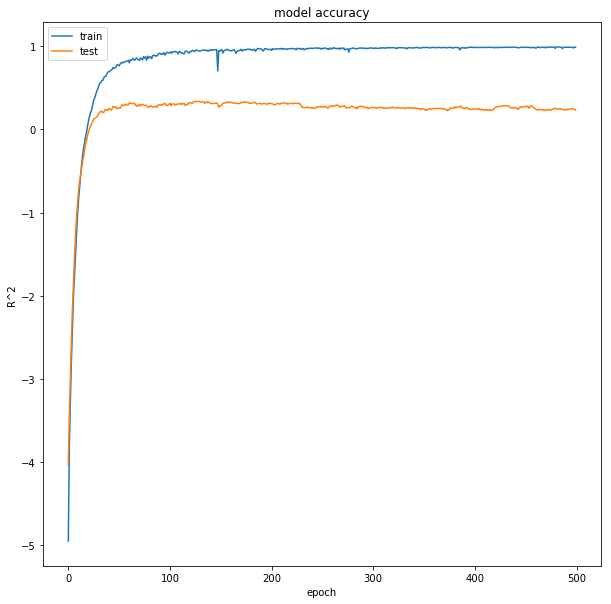

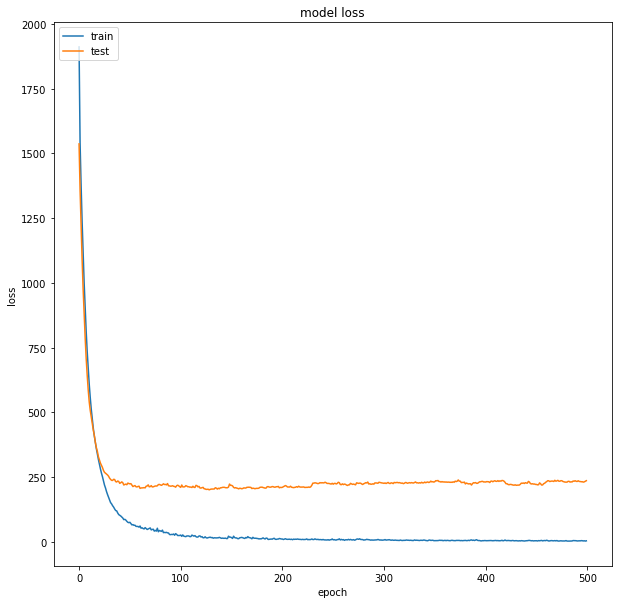

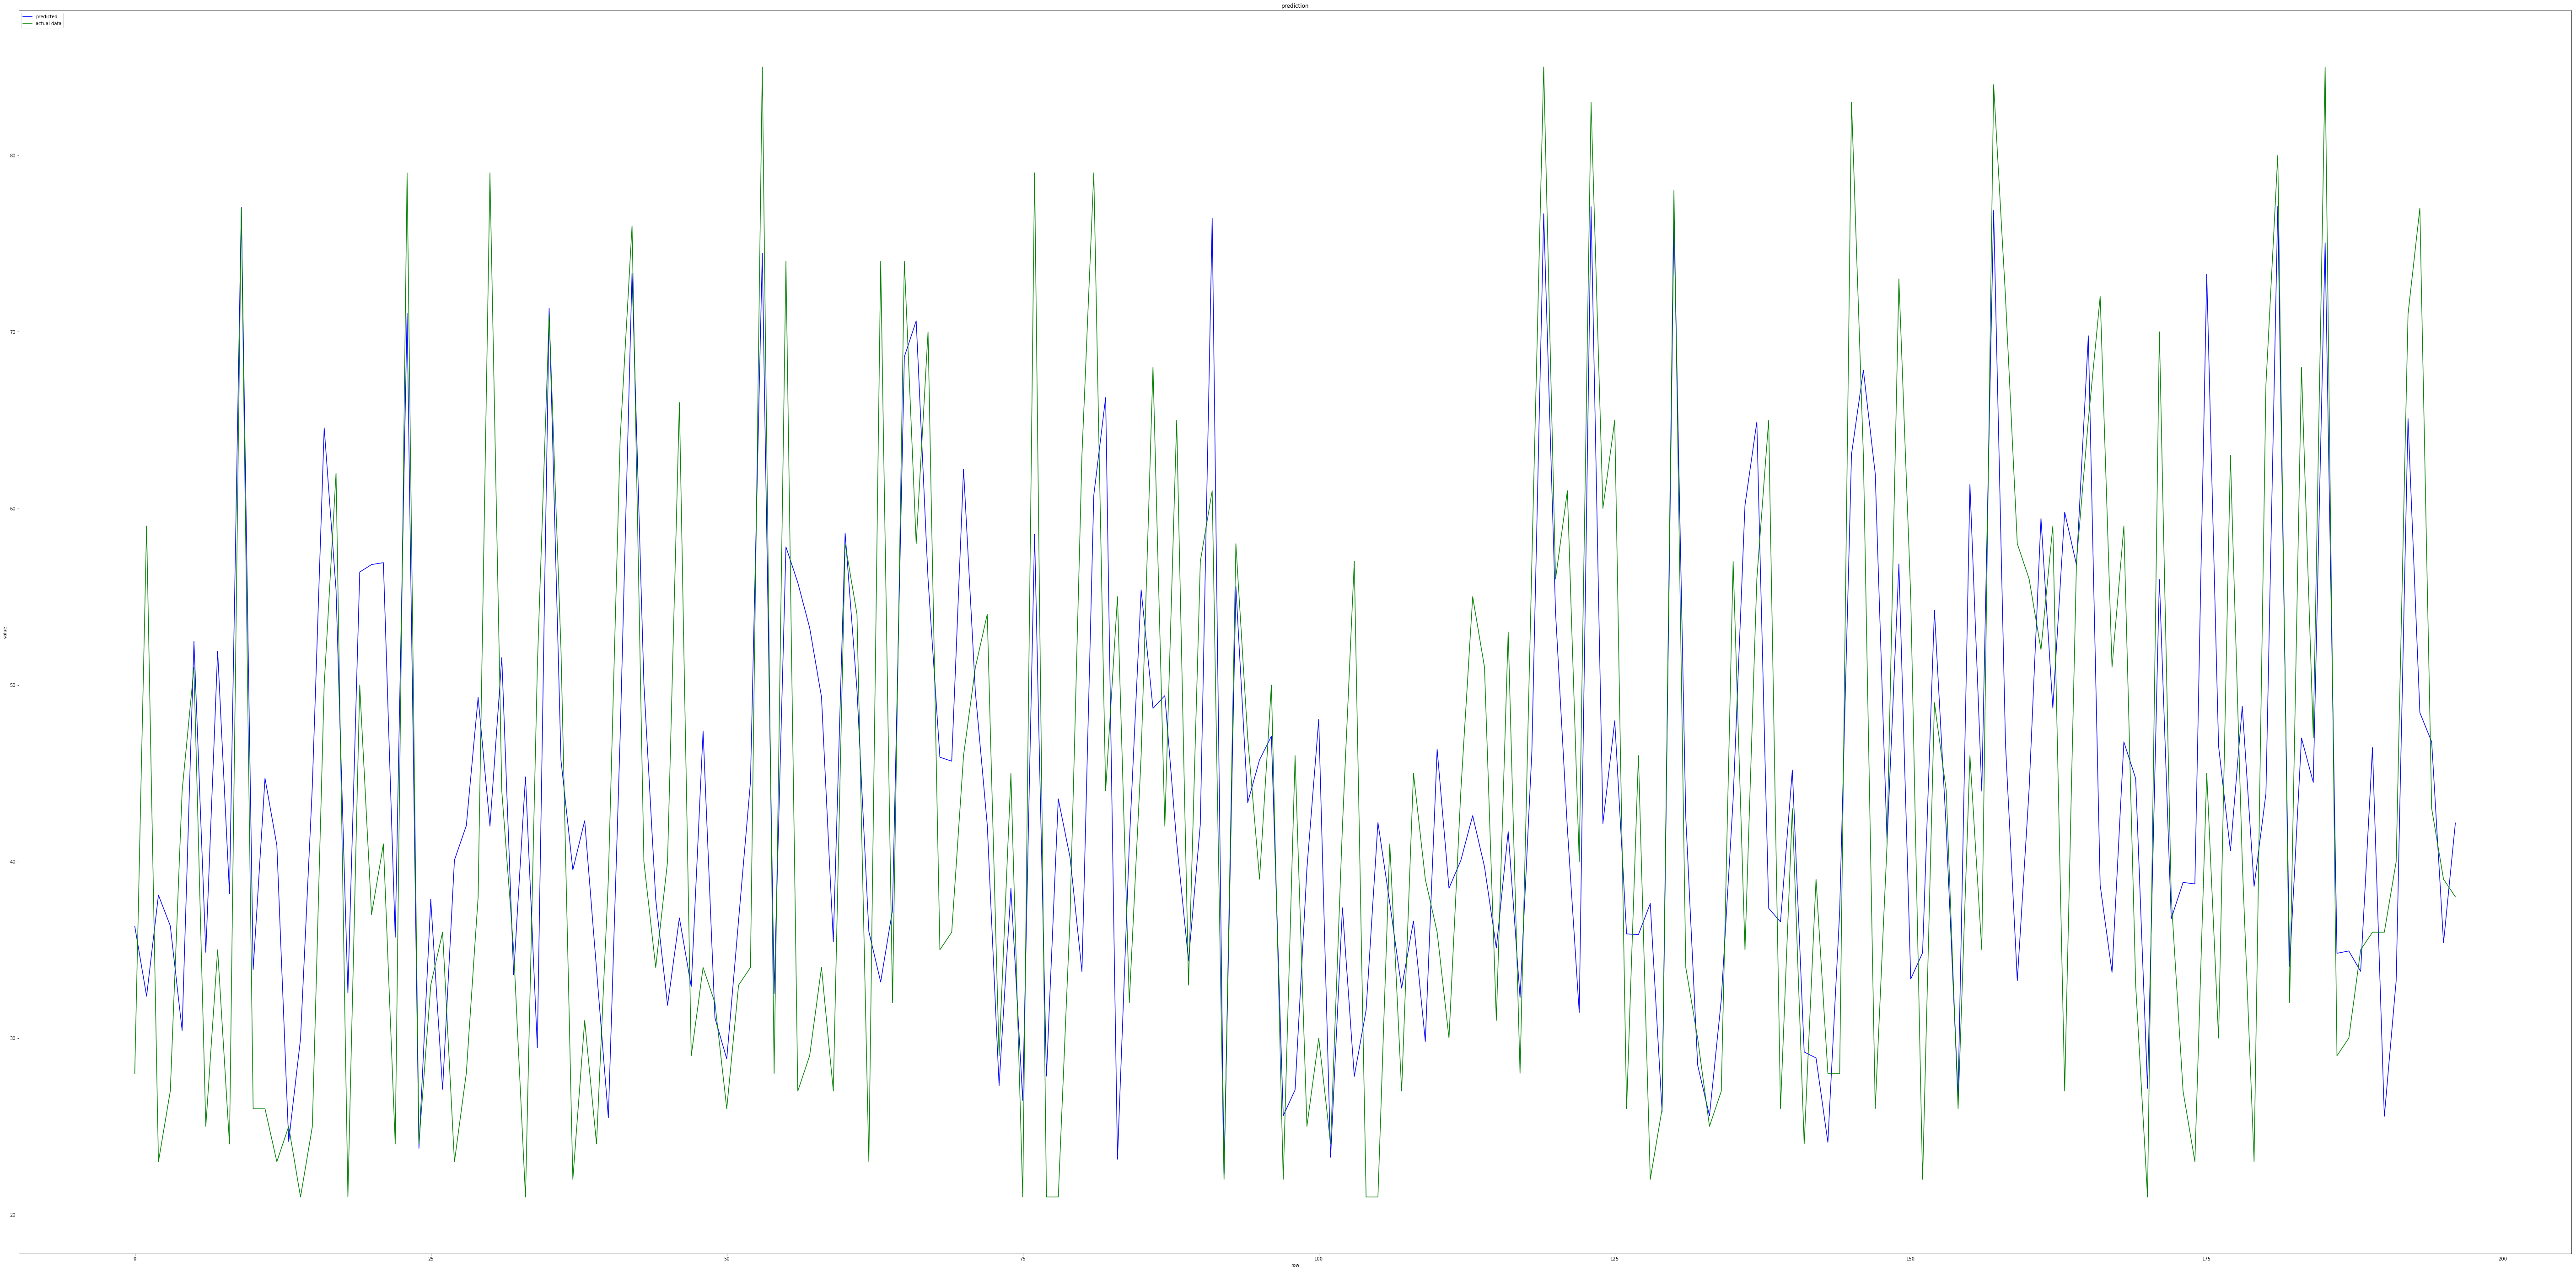

MSE train: 2.58585712761
R^2 train: 0.980329663283
MSE val: 14.1750598758
R^2 val: 0.380243167817


In [8]:
mean_mse = mean(mse_scores)
mean_r2 = mean(r2_scores)

standard_deviation_mse = mt.sqrt(sum_of_square_deviation(mse_scores,mean_mse))
standard_deviation_r2 = mt.sqrt(sum_of_square_deviation(r2_scores,mean_r2))

print('=====================')
print( 'Mean Squared Error %f'%mean_mse)
print('=====================')
print('=====================')
print( 'Stdev Squared Error %f'%standard_deviation_mse)
print('=====================')
print('=====================')
print( 'Mean R^2 %f'%mean_r2)
print('=====================')
print('=====================')
print( 'Stdev R^2 %f'%standard_deviation_r2)
print('=====================')

# prepare callbacks
callbacks = [
    #EarlyStopping(
     #   monitor='val_r2_keras', 
      #  patience=20,
       # mode='max',
        #verbose=1),
    ModelCheckpoint(
        model_path, 
        monitor='val_r2_keras', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]

# train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=seed
)

# fit estimator
history = estimator.fit(
    X_tr, 
    y_tr, 
    epochs=500,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=callbacks,
    shuffle=True
)

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model accuracy')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for loss
fig_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_loss.savefig("model_loss.png")

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path, custom_objects={'r2_keras': r2_keras})

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
predicted = estimator.predict(X_val)
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(predicted, color="blue")
plt.plot(y_val, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# check performance on train set
print('MSE train: {}'.format(mean_squared_error(y_tr, estimator.predict(X_tr))**0.5)) # mse train
print('R^2 train: {}'.format(r2_score(y_tr, estimator.predict(X_tr)))) # R^2 train

# check performance on validation set
print('MSE val: {}'.format(mean_squared_error(y_val, estimator.predict(X_val))**0.5)) # mse val
print('R^2 val: {}'.format(r2_score(y_val, estimator.predict(X_val)))) # R^2 val
pass

# predict results
res = estimator.predict(X_test).ravel()


# create df and convert it to csv
output = pd.DataFrame({ 'y': res})
output.to_csv('keras-baseline.csv', index=False)